Demo notebook for inverse problems
==================================

**Table of content**
1. [Defining an inverse problem](#defining-an-inverse-problem)
1. [Example on CelebaHQ dataset with DPS algorithm](#example-on-celebahq-dataset-with-dps-algorithm)
1. [Example on FFHQ dataset with $\Pi\text{GDM}$ algorithm](#example-on-ffhq-dataset-with--algorithm)


# Defining an inverse problem

Inverse problem,
\begin{equation*}
    y = A x + \sigma \ \epsilon
\end{equation*}
- $y$ the observation
- $A$ the degradation operator
- $\sigma \ \epsilon$ Gaussian noise $\mathcal{N}(0, \sigma I)$

Let's see how to

1. Load an image
1. Load the degradation operator $A$
1. Plot the observation $y$


## Loading an image

/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


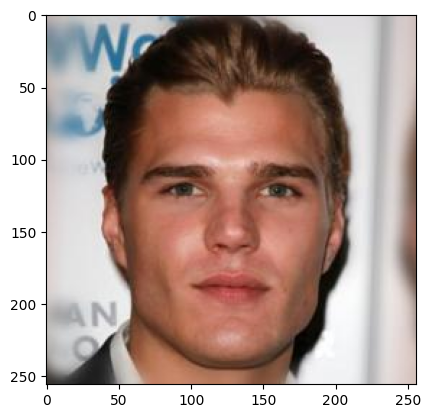

In [1]:
from utils import load_image, display_image
import matplotlib.pyplot as plt
from evaluation.perception import LPIPS

lpips =  LPIPS()
# load the image
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path)

# plot the image
fig, ax = plt.subplots()

display_image(x_origin, ax)


## Loading the degradation operator

Let's load SR16 degradation operator

It reduces the resolution of the image by $16$

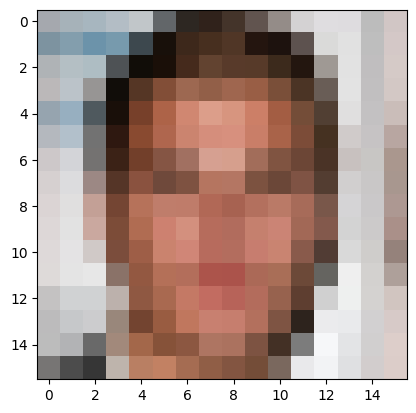

In [2]:
import math
import torch

# load the degradation operator
path_operator = f"./material/degradation_operators/sr16.pt"
degradation_operator = torch.load(path_operator, map_location="cpu")

# apply degradation operator
# NOTE: it operates on bach of images
y = degradation_operator.H(x_origin[None])

# reshape to plot the observation
# NOTE: y is a square image with 3 channels
n_channels = 3
n_pixel_per_channel = y.shape[1] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# plot the image
fig, ax = plt.subplots()
display_image(y_reshaped)

Let's add Gaussian noise with $\sigma = 0.1$

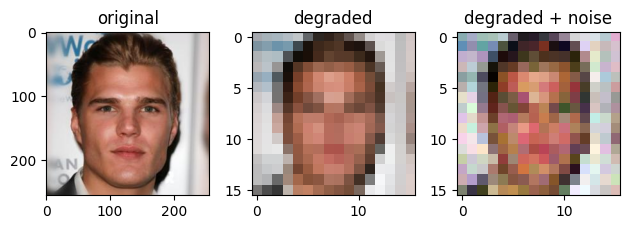

In [3]:
# add noise
sigma = 0.1
y_reshaped_noised = y_reshaped + sigma * torch.randn_like(y_reshaped)

# plot the three images side by side
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, y_reshaped_noised)
titles = ("original", "degraded", "degraded + noise")

for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()

In the end, the inverse problem can be defined using the tuple ``(y, degradation_operator, sigma)``

**Note**:
In practice, we don't have access to $x$ (in the code ``x_origin``) but only to $y$, $A$, and $\sigma$

# Example on CelebaHQ dataset with DPS algorithm

The model details and checkpoint can be found in [Hugging Face](https://huggingface.co/google/ddpm-celebahq-256)

Here, the package ``Diffusers`` is used under the hood to load the model.

Beforehand, let's load the model and perform unconditional sampling

In [4]:
import torch
from utils import load_epsilon_net
from sampling.unconditional import unconditional_sampling


# load the noise predictor with 1000 diffusion steps
device = "cuda:0"
n_steps = 1000
torch.set_default_device(device)

eps_net = load_epsilon_net("celebahq", n_steps, device)

# check unconditional generation
# NOTE: use initial noise to specify number of generated samples
initial_noise = torch.randn((1, 3, 256, 256), device=device)
generated_images = unconditional_sampling(eps_net, initial_noise, display_im=False)

# plot image
fig, ax = plt.subplots()
display_image(generated_images[0], ax)

diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]
/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args,

KeyboardInterrupt: 

Now we have all the building blocks to solve linear inverse problems.

Let's solve SR16 problem with CelebaHQ model prior using DPS algorithm [1].


.. [1] Chung, Hyungjin, et al. "Diffusion posterior sampling for general noisy inverse problems." arXiv preprint arXiv:2209.14687 (2022).


In [6]:
from dmps.data.dataloader import get_dataloader, get_dataset
import torchvision.transforms as transforms
import yaml

args = {}
args['model_config'] = './dmps/configs/model_config.yaml'
args['diffusion_config'] = './dmps/configs/diffusion_config.yaml'
args['task_config'] = './dmps/configs/sr4_config.yaml'
args['gpu'] = 0
args['save_dir'] = './saved_results'
args['seed'] = 0

def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

device = "cuda:0"
torch.set_default_device(device)

# define first the inverse problem
# load the image
transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
task_config = load_yaml(args["task_config"])
data_config = task_config['data']

dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path, device)

# load the degradation operator
path_operator = f"./material/degradation_operators/outpainting_expand.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
print(y.shape)
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

inverse_problem = (y, degradation_operator, sigma)

torch.Size([1, 18252])


lambda = {0.5, 1, 1.5}
n_steps = {100, 300, 500}
K = {n_steps//10, nsteps//5, nsteps//2}
sigma = {0.01, 0.05, 0.1}

In [ ]:
n_channels, width, height

diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]
/home/obanmarcos/PhD/Projects/GM Hackathon/hackathon_starter_kit/venv-hackathon/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args,

DMPS running time: 19.053070306777954
PSNR: 9.4958553833791


/tmp/ipykernel_171101/334820725.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


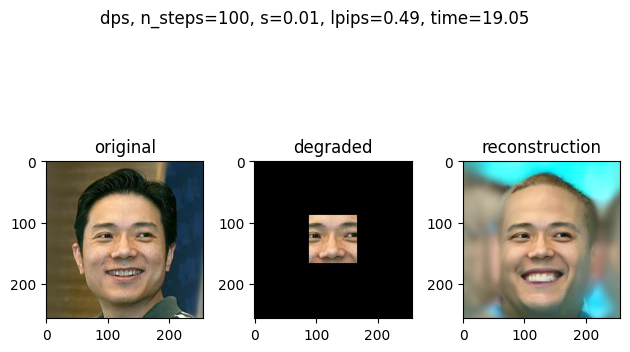

In [7]:
from utils import load_epsilon_net
from sampling.dps_dpms import dps_dpms
from sampling.dps import dps
import itertools
import time
import numpy as np
from dmps.util.img_utils import clip, clear_color, normalize_np
from skimage.metrics import peak_signal_noise_ratio
import math
import os

lamb = [0.5, 1, 1.5]
n_steps = [100, 300, 500]
sigmas = [0.01, 0.05, 0.1]
psnr_results = []

device = "cuda:0"
out_path = "saved_results/outpainting_expand"

for lam in lamb:
    for n_step in n_steps:
        for sigma in sigmas:
            K = [n_step//10, n_step//5, n_step//2]
            eps_net = load_epsilon_net("celebahq", n_step, device)
            for k in K:
                # Iterate over dataset
                for i, ref_img in enumerate(loader):
                    if i == 1:
                        break
                    for method in ["dps", "dps_dpms"]:
                            
                        initial_noise = torch.randn((1, 3, 256, 256), device=device)
                        
                        y = degradation_operator.H(ref_img[None].to(device))
                        
                        y = y.squeeze(0)
                        y = y + sigma * torch.randn_like(y)
                        inverse_problem = (y, degradation_operator, sigma)

                        DMPS_start_time = time.time()
                        if method == "dps":
                            reconstruction = dps(initial_noise, inverse_problem, eps_net)
                        if method == "dps_dpms":
                            reconstruction = dps_dpms(initial_noise, inverse_problem, eps_net)
                        DMPS_end_time = time.time()
                        print('DMPS running time: {}'.format(DMPS_end_time - DMPS_start_time))
                        psnr = peak_signal_noise_ratio(ref_img[0].cpu().numpy(), reconstruction[0].cpu().numpy())
                        lpips_score = lpips.score(reconstruction.clamp(-1, 1), ref_img)
                        psnr_results.append([psnr])
                        print('PSNR: {}'.format(psnr))

                        fname = str(i).zfill(5) + '.png'
                        
                        fig, axes = plt.subplots(1, 3)                    
                        y_reshaped =  -torch.ones(3 * 256 * 256, device=device)
                        y_reshaped[: y.shape[0]] = y
                        y_reshaped = degradation_operator.V(y_reshaped[None])
                        y_reshaped = y_reshaped.reshape(3, 256, 256)

                        images = (ref_img, y_reshaped, reconstruction[0])
                        titles = ("original", "degraded", "reconstruction")

                        # display figures
                        for ax, img, title in zip(axes, images,titles):
                            display_image(img, ax)
                            ax.set_title(title)
                    
                        fig.tight_layout()
                        fig.show()

                        if method == "dps_dpms":
                            fig.suptitle(f"{method}, n_steps={n_step}, s={sigma}, k={k}, lpips={round(lpips_score.item(),2)}, time={round(DMPS_end_time-DMPS_start_time,2)}")
                            fig.savefig(f"saved_results/outpainting_expand/dpms_dps/input/{i}_{k}_{sigma}_{n_step}.pdf", bbox_inches = 'tight')
                        else:
                            fig.suptitle(f"{method}, n_steps={n_step}, s={sigma}, lpips={round(lpips_score.item(),2)}, time={round(DMPS_end_time-DMPS_start_time,2)}")

                            fig.savefig(f"saved_results/outpainting_expand/dps/input/{i}_{sigma}_{n_step}.pdf", bbox_inches = 'tight')

                        break
                    break
                break
            break
        break
    break

In [14]:
degradation_operator.singulars().shape

torch.Size([18252])

In [ ]:
print(y.shape)

In [ ]:
# plot results

# reshape y
n_channels = 3
n_pixel_per_channel = y.shape[0] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# init figure
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, reconstruction[0])
titles = ("original", "degraded", "reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()

# Example on FFHQ dataset with $\Pi\text{GDM}$ algorithm

The model details can be found in [Diffusion Posterior Sampling for General Noisy Inverse Problems](https://arxiv.org/abs/2209.14687) in the Experiment section.

The model checkpoint, ``ffhq_10m.pt``, can be downloaded [here](https://drive.google.com/drive/folders/1jElnRoFv7b31fG0v6pTSQkelbSX3xGZh)

Beforehand, let's load the model and perform unconditional sampling

In [ ]:

# load the noise predictor with 500 diffusion steps
device = "cuda:0"
n_steps = 1000
torch.set_default_device(device)

eps_net = load_epsilon_net("ffhq", n_steps, device)

# check unconditional generation
# NOTE: use initial noise to specify number of generated samples
initial_noise = torch.randn((1, 3, 256, 256), device=device)
generated_images = unconditional_sampling(eps_net, initial_noise, display_im=False)

# plot image
fig, ax = plt.subplots()
display_image(generated_images[0], ax)

Now let's solve an inpainting problem with FFHQ prioir using $\Pi\text{GDM}$ algorithm [1]

.. [1] Song, Jiaming, et al. "Pseudoinverse-guided diffusion models for inverse problems." International Conference on Learning Representations. 2023.

In [ ]:
device = "cuda:0"
torch.set_default_device(device)


# define first the inverse problem

# load the image
img_path = "./material/ffhq_img/00018.png"
x_origin = load_image(img_path, device)

# load the degradation operator
path_operator = f"./material/degradation_operators/inpainting_middle.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

inverse_problem = (y, degradation_operator, sigma)


This algorithm leverages the SVD decomposition of the degradation operator $A = U^\top \Sigma V$

Therefore, let's use ``EpsilonNetSVD`` to make the right transformations.

In [ ]:
from utils import load_epsilon_net
from sampling.pgdm import pgdm_svd
from sampling.epsilon_net import EpsilonNetSVD

# load model with 500 diffusion steps
n_steps = 500
eps_net = load_epsilon_net("ffhq", n_steps, device)

eps_net_svd = EpsilonNetSVD(
        net=eps_net.net,
        alphas_cumprod=eps_net.alphas_cumprod,
        timesteps=eps_net.timesteps,
        H_func=degradation_operator,
        device=device,
    )

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)
reconstruction = pgdm_svd(initial_noise, inverse_problem, eps_net_svd)

In [ ]:
# plot results

# reshape y
y_reshaped =  -torch.ones(3 * 256 * 256, device=device)
y_reshaped[: y.shape[0]] = y
y_reshaped = degradation_operator.V(y_reshaped[None])
y_reshaped = y_reshaped.reshape(3, 256, 256)


# init figure
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, reconstruction[0])
titles = ("original", "degraded", "reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()